In [1]:
import os 
print(os.getcwd())

os.chdir('/Users/danielsuarez-mash/Documents/ONS/Courses/Geospatial_Hackathon/southampton')

/Users/danielsuarez-mash


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

# Key questions

1. How many charging points are there per person? (DONE)
  - How many fast chargers are there per person?
2. On avg, what is the travelling distance to these charging points from home?
3. How many vehicles can charge at one time in the whole of Southampton?
4. What proportion of charging points tend to be logged in OpenStreetMap compared to ZapMap? 

In [3]:
# Install pyrosm
# !pip install pyrosm

In [4]:
# !pip install pandana

In [5]:
# Import dependencies
from pyrosm import OSM, get_data
import pandas as pd
import geopandas as gpd
import fiona
import matplotlib.pyplot as plt
import pandana

### County level

In [6]:
county = 'hampshire'

# get data for county
fp = get_data(county)
osm = OSM(fp)

In [7]:
# get charging points for county
custom_filter = {'amenity': ['charging_station']}
pois = osm.get_pois(custom_filter=custom_filter)

petrol_station_filter = {'amenity': ['fuel']}
petrol_stations = osm.get_pois(custom_filter=petrol_station_filter)

/Users/danielsuarez-mash/opt/anaconda3/envs/geospatial/lib/python3.10/site-packages/pyrosm/pyrosm.py:576: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  gdf = get_poi_data(
/Users/danielsuarez-mash/opt/anaconda3/envs/geospatial/lib/python3.10/site-packages/pyrosm/pyrosm.py:576: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  gdf = get_poi_data(


In [8]:
# get driving network for county
nodes, edges = osm.get_network(network_type="driving", nodes=True)

In [9]:
# convert network to routable graph
G = osm.to_graph(nodes, edges, graph_type="pandana")

Generating contraction hierarchies with 8 threads.
Setting CH node vector of size 750630
Setting CH edge vector of size 1469742
Range graph removed 1388022 edges of 2939484
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


In [10]:
# For simplicity, ensure all charging stations are represented as points
pois["geometry"] = pois.centroid
pois = pois.dropna(subset=["lon", "lat"])

/var/folders/2h/_wmbwnls5lvc428lw93thhb40000gn/T/ipykernel_27194/2161115970.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  pois["geometry"] = pois.centroid


#### What areas are within 2km of a charging station?

In [11]:
# Precompute distances up to 2000 meters
# Notice using long distance with large network can consume memory quite a bit
G.precompute(2000)

In [12]:
# Attach restaurants to Pandana graph
G.set_pois(category="charging_stations", maxdist=2000, maxitems=10, 
           x_col=pois.lon, y_col=pois.lat)

/Users/danielsuarez-mash/opt/anaconda3/envs/geospatial/lib/python3.10/site-packages/pandana/network.py:660: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/Users/danielsuarez-mash/opt/anaconda3/envs/geospatial/lib/python3.10/site-packages/pandana/network.py:668: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


In [ ]:
# For each node in the network find distances to 5 closest restaurants (up to 2000 meters)
nearest_five = G.nearest_pois(5000, "charging_stations", num_pois=5)

In [ ]:
# which nodes have a charging point less than 2km away?
nodes_of_interest = nearest_five[nearest_five[1]!=2000].index
nodes_of_interest

In [ ]:
plt.style.use('fivethirtyeight')

# what do the nodes and edges look like?
figure, axes = plt.subplots(figsize=(20,10))

# all nodes
nodes.plot(markersize=0.1, ax=axes)

# nodes with a charging station within 2km
nodes[nodes['id'].isin(nodes_of_interest)].plot(markersize=0.1, ax=axes, cmap='Reds')

# charging stations
pois.plot(ax=axes, color='g')

# cosmetics
axes.set_title('Network Nodes within 2km of a Charging Station')

### Town level

#### Land use

In [80]:
# define town of interest
town = 'Southampton'

In [81]:
# get boundaries for all UK Local Authority Districts
boundaries = gpd.read_file('LAD_(Dec_2021)_GB_BFC/LAD_(Dec_2021)_GB_BFC.shp')

In [82]:
town_boundary = boundaries[boundaries['LAD21NM'] == town]
town_boundary['geometry']
town_boundary = town_boundary.to_crs('EPSG:4326')

In [83]:
town_chargers = pois.clip(town_boundary)
town_edges = edges.clip(town_boundary)
town_petrol_stn = petrol_stations.clip(town_boundary)

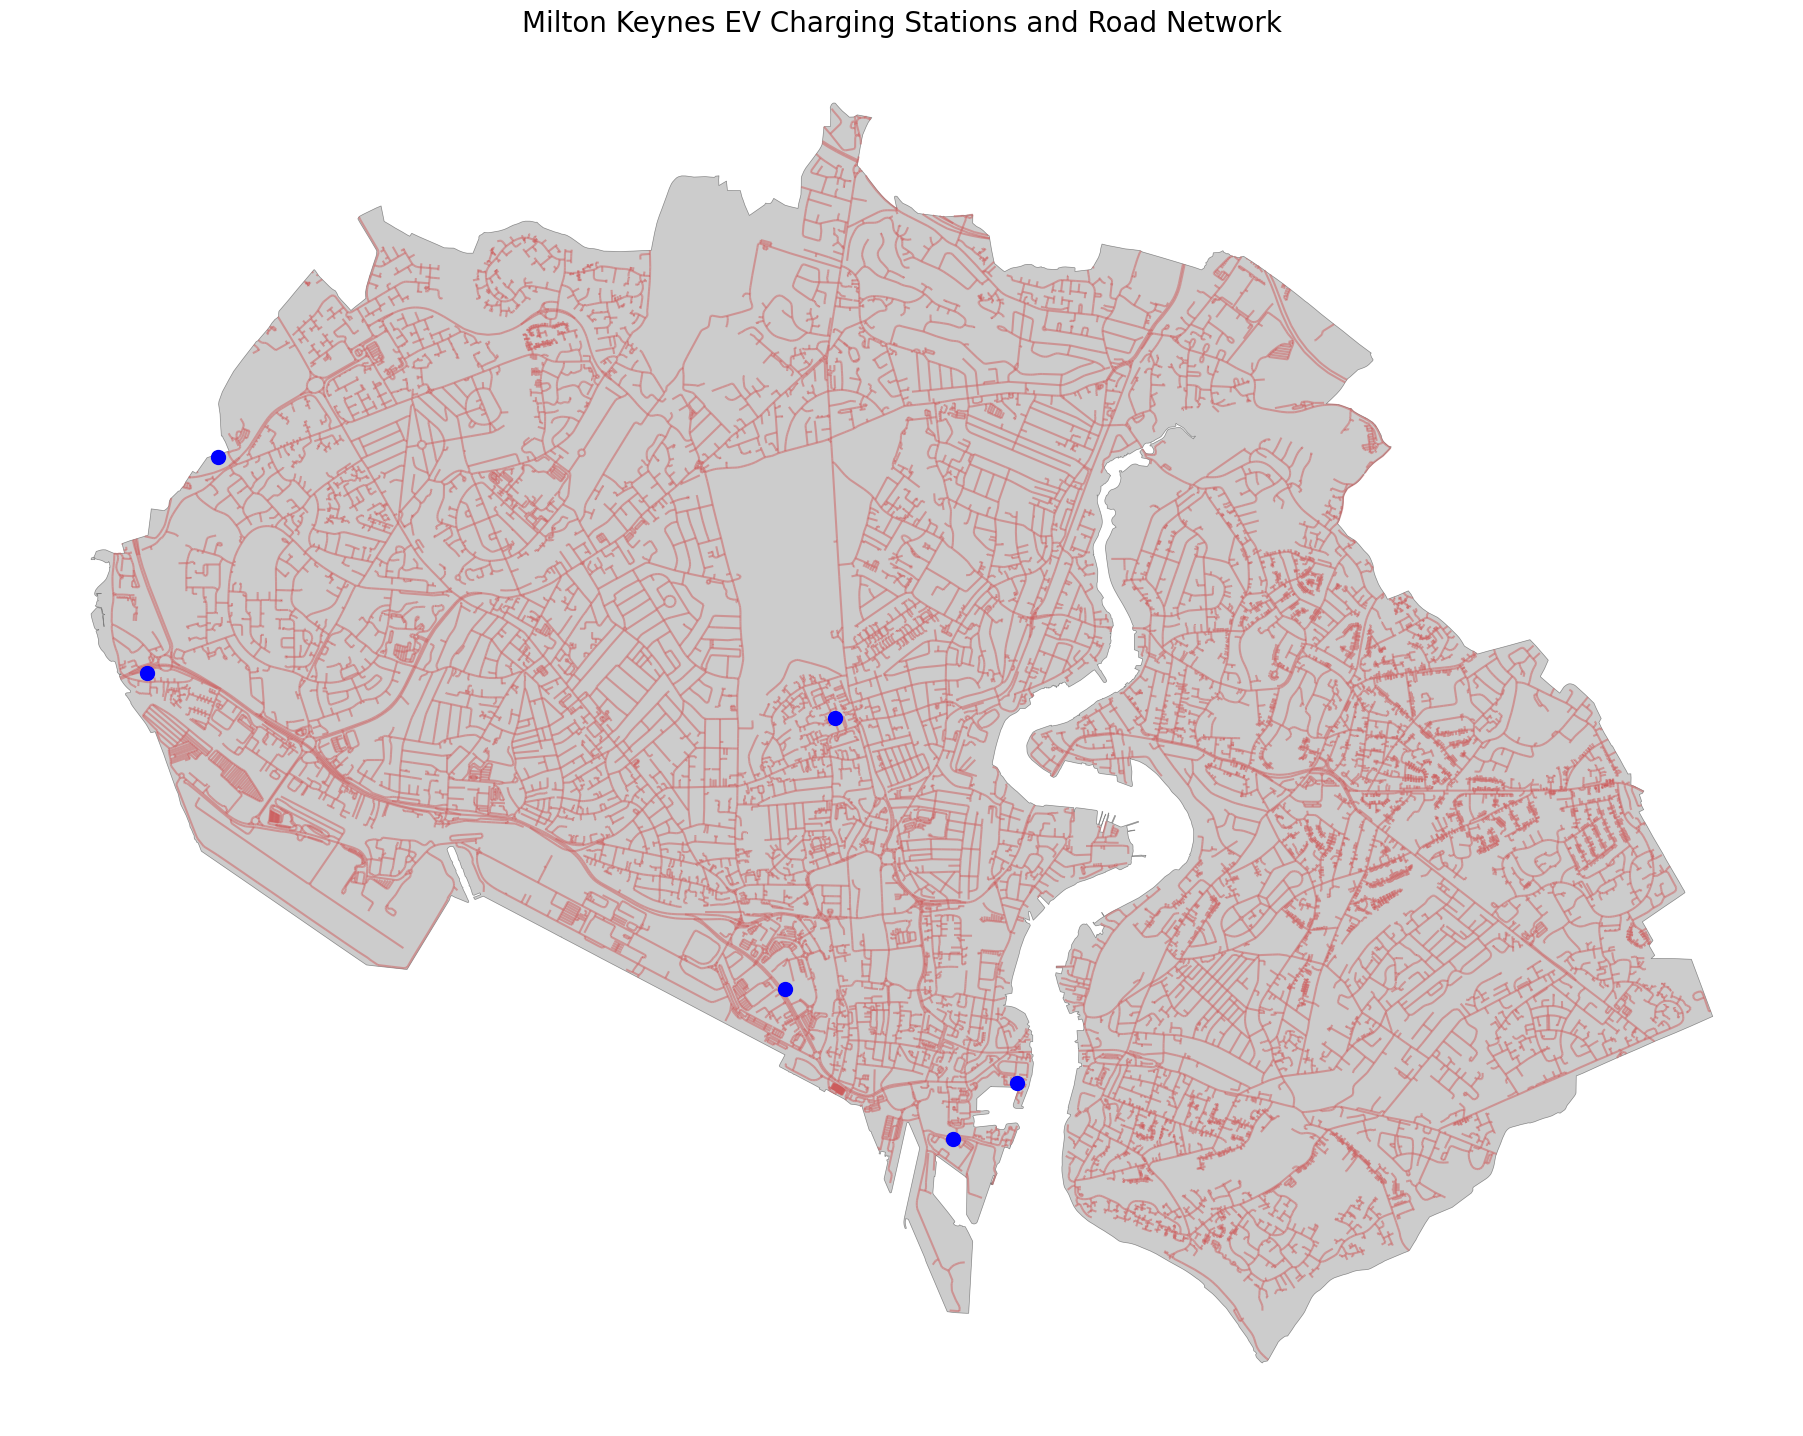

In [85]:
plt.style.use('default')

# Plot the data
fig, ax = plt.subplots(figsize=(24, 18))
town_boundary.plot(ax=ax, alpha=0.4, color="grey", zorder=1)
town_boundary.boundary.plot(ax=ax, alpha=0.4, color="black", linewidth=0.5, zorder=2)
town_edges.plot(ax=ax, alpha = 0.5, color='indianred',zorder=3)
town_chargers.plot(ax=ax, color='blue', zorder=4, markersize=100)
plt.title('Milton Keynes EV Charging Stations and Road Network', fontsize=20)
ax.axis('off');

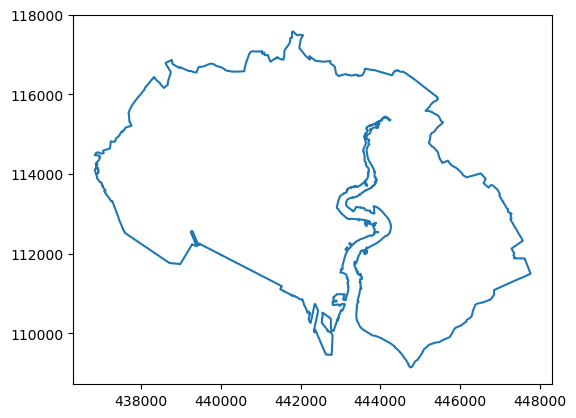

In [86]:
# get boundary for town LAD
ax = boundaries[boundaries['LAD21NM'] == town].boundary.plot()

<AxesSubplot:>

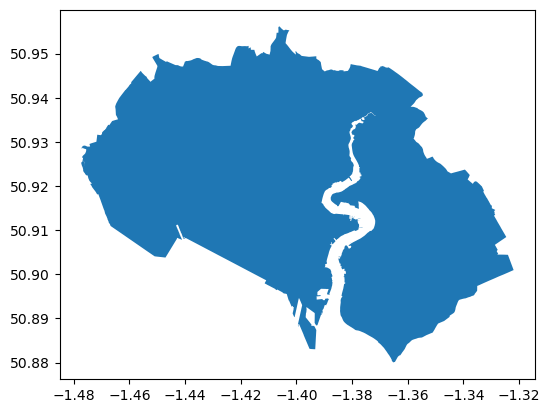

In [87]:
town_boundary.plot()

In [88]:
# get landuse data
landuse = osm.get_landuse()

# reduce landuse categories
landuse_red = landuse[(landuse['landuse'] == 'residential') |
           (landuse['landuse'] == 'retail') |
           (landuse['landuse'] == 'commercial') |
           (landuse['landuse'] == 'industrial')]

/Users/danielsuarez-mash/opt/anaconda3/envs/geospatial/lib/python3.10/site-packages/pyrosm/pyrosm.py:323: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  gdf = get_landuse_data(


In [89]:
# reduce data to town boundary
town_landuse = landuse_red.clip(town_boundary)

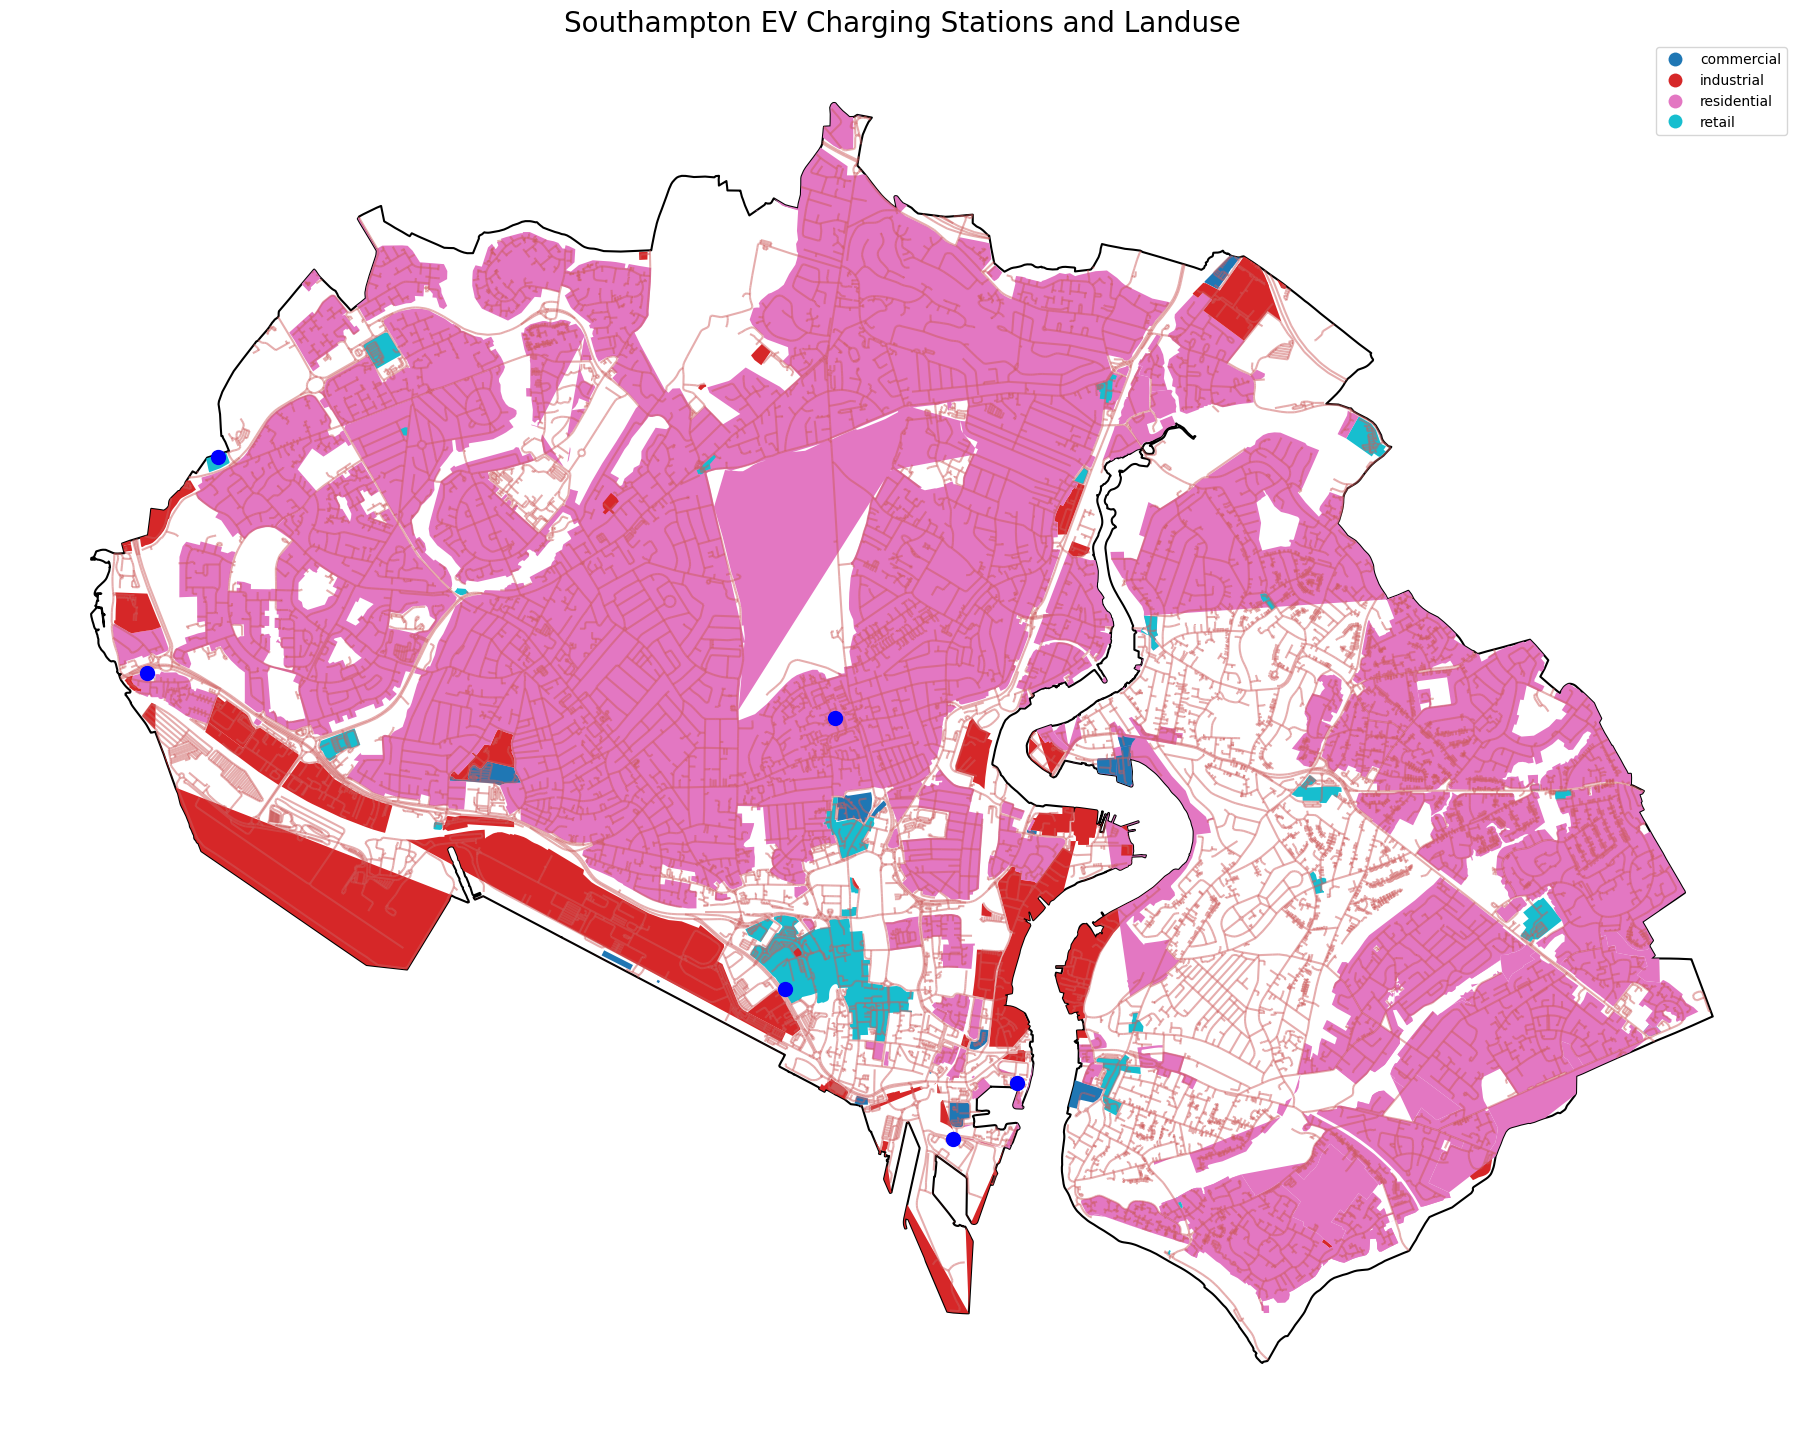

In [90]:
plt.style.use('default')

# Plot the data
fig, ax = plt.subplots(figsize=(24, 18))
town_boundary.boundary.plot(ax=ax, color="black", zorder=1)
town_landuse.plot(ax=ax, column='landuse', legend=True, figsize=(10,6), zorder=2);
town_edges.plot(ax=ax, alpha = 0.5, color='indianred',zorder=3)
town_chargers.plot(ax=ax, color='blue',zorder=4, markersize=100)
plt.title('{} EV Charging Stations and Landuse'.format(town), fontsize=20)
ax.axis('off');

#### Population Density

In [54]:
# Read in census data for pop estimates Mid 2020
census = pd.read_excel('sape23dt13mid2020lsoabroadagesestimatesunformatted.xlsx',
              sheet_name = 'Mid-2020 Persons',skiprows=4)

/Users/danielsuarez-mash/opt/anaconda3/envs/geospatial/lib/python3.10/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [91]:
# Extract total population and LSOA code from census data
total_pop = census[['LSOA Code','All Ages']]

In [92]:
# lsoa boundaries
lsoa = gpd.read_file('LSOA_(Dec_2021)_Boundaries_Full_Clipped_EW_(BFC)/LSOA_(Dec_2021)_Boundaries_Full_Clipped_EW_(BFC).shp')

In [93]:
# change CRS
lsoa = lsoa.to_crs('EPSG:4326')

In [94]:
# Clip to MK boundary (can also do by applying mask for Milton Keynes in LSOA21NM)
town_lsoa_int = lsoa.clip(town_boundary)
town_lsoa_diff = town_boundary.overlay(lsoa, how='identity')
town_lsoa = town_lsoa_int.append(town_lsoa_diff)

/Users/danielsuarez-mash/opt/anaconda3/envs/geospatial/lib/python3.10/site-packages/geopandas/geodataframe.py:2196: UserWarning: `keep_geom_type=True` in overlay resulted in 105 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  return geopandas.overlay(
/var/folders/2h/_wmbwnls5lvc428lw93thhb40000gn/T/ipykernel_25585/3847275888.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  town_lsoa = town_lsoa_int.append(town_lsoa_diff)


In [95]:
# Merge the two dataframes (lsoa must go first so that it remains a geopandas dataframe)
town_lsoa_pop = town_lsoa.merge(total_pop, left_on='LSOA21CD', right_on='LSOA Code')

In [96]:
town_lsoa_pop['Pop Density'] =  town_lsoa_pop['All Ages'] / town_lsoa_pop['Shape__Are']

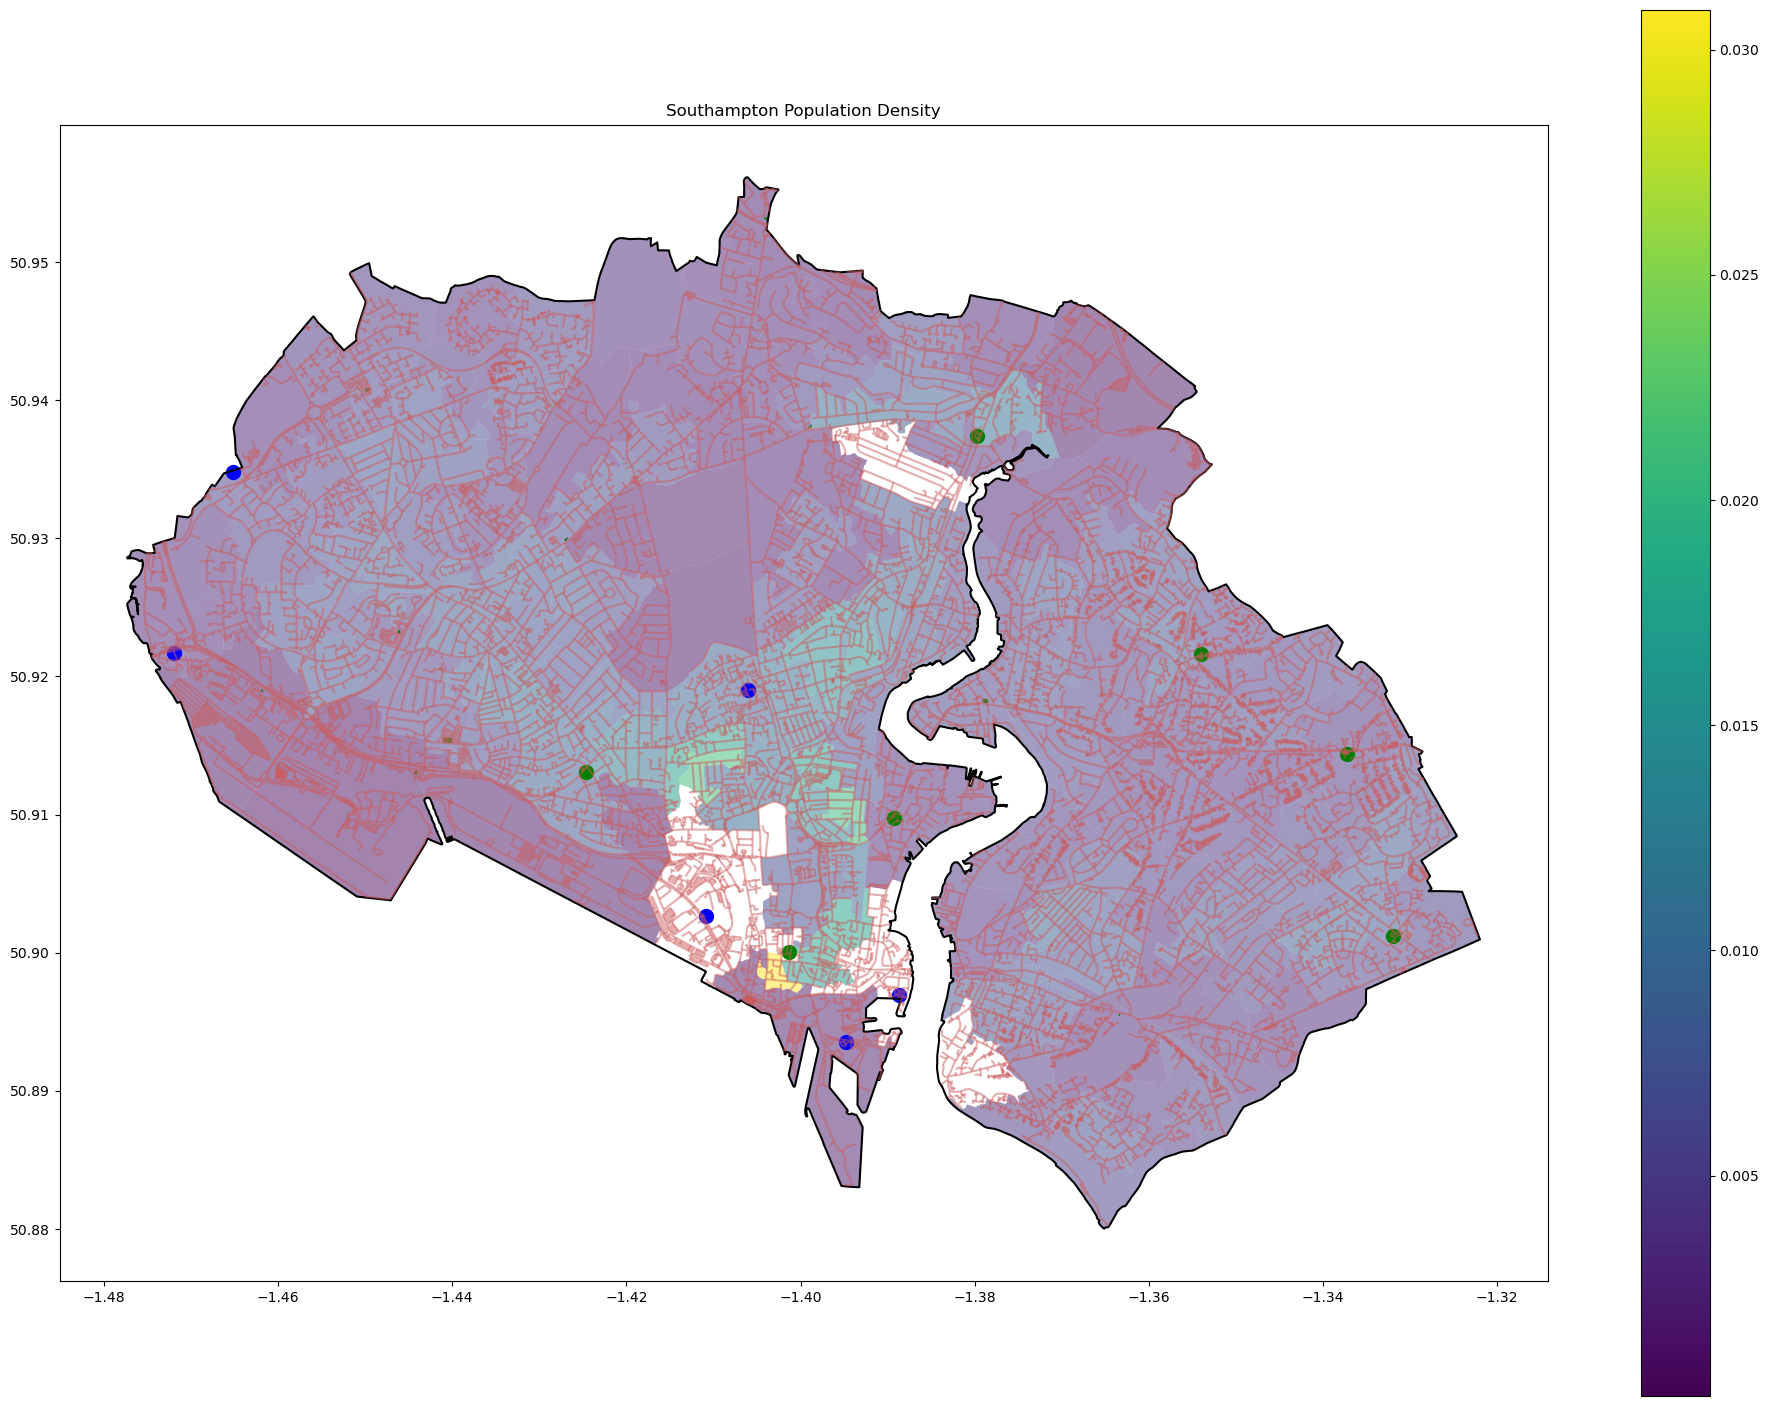

In [97]:
plt.style.use('default')

# Plot the data
fig, ax = plt.subplots(figsize=(24, 18))
town_boundary.boundary.plot(ax=ax, color="black")
town_lsoa_pop.plot(ax=ax, column = 'Pop Density', alpha=0.5, legend=True)
town_edges.plot(ax=ax, alpha = 0.5, color='indianred')
town_chargers.plot(ax=ax, color='blue', markersize=100)
town_petrol_stn.plot(ax=ax, color='green', markersize=100)
plt.title("{} Population Density".format(town));



```
# This is formatted as code
```

### Population analysis

Population of  Milton Keynes  is  270203
In  Milton Keynes , there are  0.0  charging points per person.
In  Milton Keynes , there are  0.0  charging points per 100,000 people.


(0.0, 20.0)

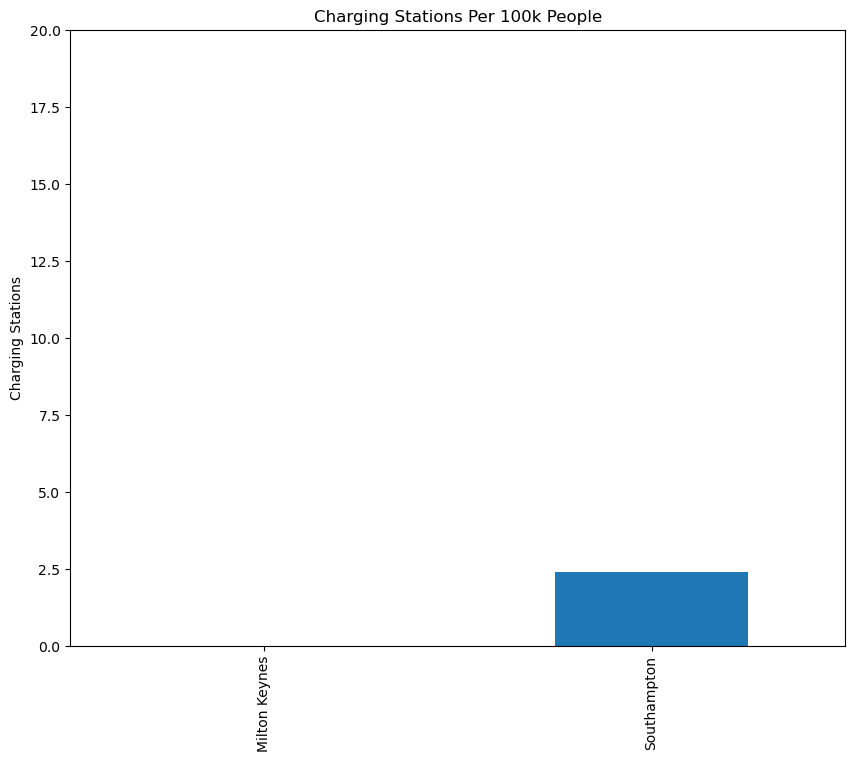

In [35]:
# charging points per person

# get population estimates (mid-2020)
population_df = pd.read_excel('ukpopestimatesmid2020on2021geography.xls', sheet_name = "MYE2 - Persons", header = 7)
town_population = population_df[population_df["Name"]== town]["All ages"].values[0]
print("Population of ", "{}".format(town), " is ", town_population)

# calculate charging points per person
points_per_person = len(town_chargers)/town_population
print("In ", "{}".format(town), ", there are ", round(points_per_person,1), " charging points per person.")

points_per_100k_people = len(town_chargers)/(town_population/100000)
print("In ", "{}".format(town), ", there are ", round(points_per_100k_people,1), " charging points per 100,000 people.")

# plot a chart
df = pd.DataFrame(data=[points_per_100k_people, 2.4], columns=['points_per_100k_people'], index=[town, 'Southampton'])
fig, axes = plt.subplots(figsize=(10,8))
df.plot(kind='bar', ax=axes, legend=None)
axes.set_title('Charging Stations Per 100k People')
axes.set_ylabel('Charging Stations')
axes.set_ylim(top=20)